#### A notebook for visualizing inputs and outputs for this project

In [26]:
import geopandas as gpd
import rasterio
import rioxarray as rio
import matplotlib.pyplot as plt
import folium
import contextily as ctx
import os

In [27]:
base_dir = "../../"
raw_dir = os.path.join(base_dir, 'data', 'raw')
processed_dir = os.path.join(base_dir, "data", "processed")
results_dir = os.path.join(base_dir, 'data', "results")

In [28]:
# --- Load Rasters ---
mndwi_2007 = rio.open_rasterio(os.path.join(processed_dir, "2007_mndwi.tif"), masked=True)
mndwi_2016 = rio.open_rasterio(os.path.join(processed_dir, "2016_mndwi.tif"), masked=True)
mndwi_2020 = rio.open_rasterio(os.path.join(processed_dir, "2020_mndwi.tif"), masked=True)
mndwi_2025 = rio.open_rasterio(os.path.join(processed_dir, "2025_mndwi.tif"), masked=True)
mask_2007 = rio.open_rasterio(os.path.join(processed_dir, "2007_mndwi_watermask.tif"), masked=True)
mask_2016 = rio.open_rasterio(os.path.join(processed_dir, "2016_mndwi_watermask.tif"), masked=True)
mask_2020 = rio.open_rasterio(os.path.join(processed_dir, "2020_mndwi_watermask.tif"), masked=True)
mask_2025 = rio.open_rasterio(os.path.join(processed_dir, "2025_mndwi_watermask.tif"), masked=True)
dem = rio.open_rasterio(os.path.join(raw_dir, "dem.tif"), masked=True)

# --- Load Vectors ---
vector_2007 = gpd.read_file(os.path.join(processed_dir, "2007_mndwi_watermask.shp"))
vector_2016 = gpd.read_file(os.path.join(processed_dir, "2016_mndwi_watermask.shp"))
vector_2020 = gpd.read_file(os.path.join(processed_dir, "2020_mndwi_watermask.shp"))
vector_2025 = gpd.read_file(os.path.join(processed_dir, "2025_mndwi_watermask.shp"))

dissolved_2007 = gpd.read_file(os.path.join(results_dir, "lake_2007.shp"))
dissolved_2016 = gpd.read_file(os.path.join(results_dir, "lake_2016.shp"))
dissolved_2020 = gpd.read_file(os.path.join(results_dir, "lake_2020.shp"))
dissolved_2025 = gpd.read_file(os.path.join(results_dir, "lake_2025.shp"))

growth_area = gpd.read_file(os.path.join(results_dir, 'growth_area.shp'))
buildings = gpd.read_file(os.path.join(processed_dir, 'buildings.gpkg'))
roads = gpd.read_file(os.path.join(processed_dir, 'roads.gpkg'))
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
facilities = gpd.read_file(os.path.join(processed_dir, 'facilities.gpkg'))
facilities = facilities[facilities.geom_type.isin(['[Polygon]'])]


In [29]:
buildings = buildings.to_crs(growth_area.crs)
roads = roads.to_crs(growth_area.crs)
facilities = facilities.to_crs(growth_area.crs)
# Intersection — what lies within the expanded lake area
submerged_buildings = gpd.overlay(buildings, growth_area, how="intersection")
submerged_roads = gpd.overlay(roads, growth_area, how="intersection")
submerged_facilities = gpd.overlay(facilities, growth_area, how="intersection")

In [30]:
growth_area = growth_area.to_crs(dissolved_2007.crs)
submerged_buildings = submerged_buildings.to_crs(dissolved_2007.crs)
submerged_roads = submerged_roads.to_crs(dissolved_2007.crs)
submerged_facilities = submerged_facilities.to_crs(dissolved_2007.crs)

In [31]:
# --- CRS alignment check ---
print("Raster CRS:", dem.rio.crs)
print("Vector CRS:", vector_2016.crs)
if vector_2016.crs != mndwi_2016.rio.crs:
    vector_2016 = vector_2016.to_crs(mndwi_2016.rio.crs)


Raster CRS: EPSG:32636
Vector CRS: EPSG:32636


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11920\989932809.py:7: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  submerged_facilities.plot(ax=ax, color="orange", markersize=20, label="Submerged Facilities")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11920\989932809.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


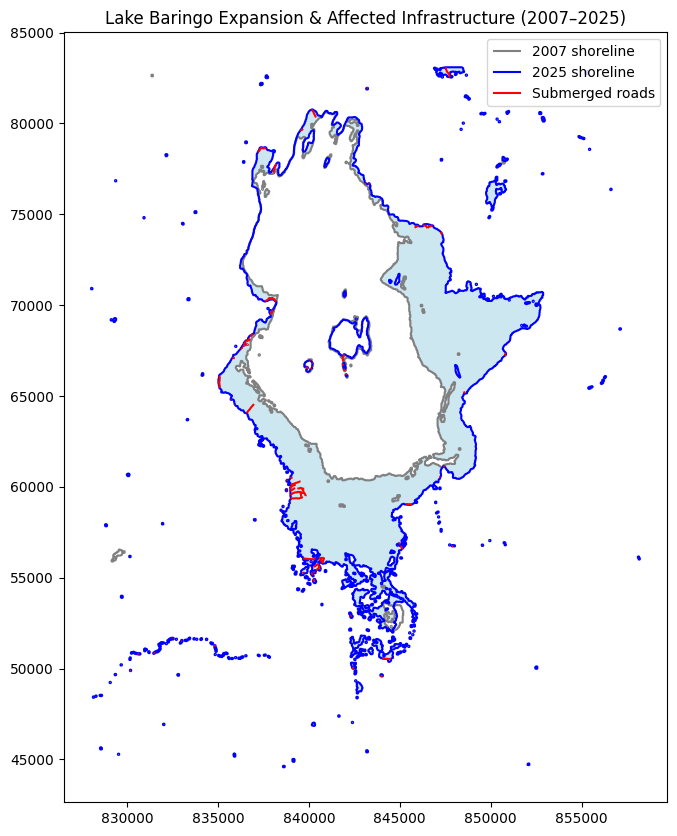

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_2007.boundary.plot(ax=ax, color="gray", label="2007 shoreline")
dissolved_2016.boundary.plot(ax=ax, color="green", label="2016 shoreline")
dissolved_2025.boundary.plot(ax=ax, color="blue", label="2025 shoreline")
growth_area.plot(ax=ax, color="lightblue", alpha=0.6, label="Expansion area")
submerged_buildings.plot(ax=ax, color="red", markersize=10, label="Submerged buildings")
submerged_roads.plot(ax=ax, color="red", markersize=10, label="Submerged roads")
submerged_facilities.plot(ax=ax, color="orange", markersize=20, label="Submerged Facilities")
plt.legend()
plt.title("Lake Baringo Expansion & Affected Infrastructure (2007–2025)")
plt.show()

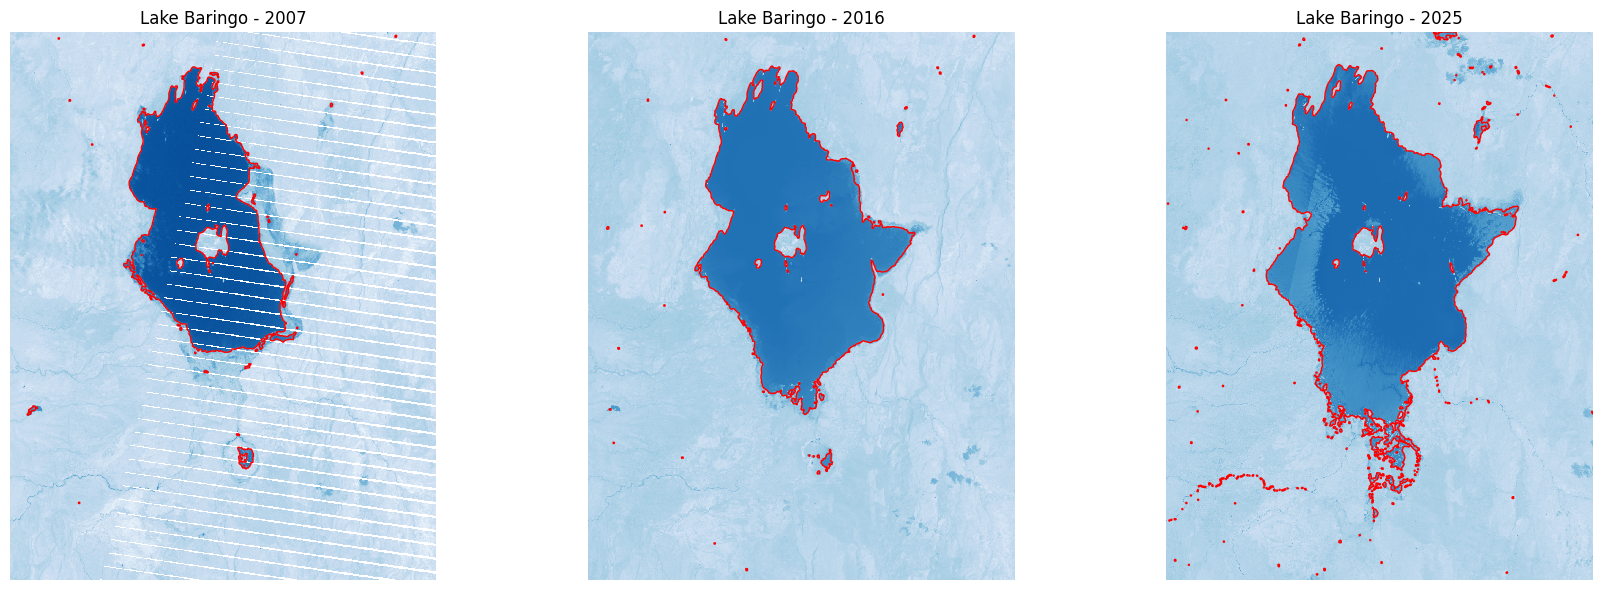

In [33]:
# --- Static comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (mndwi, vec, year) in zip(
    axes,
    [
        (mndwi_2007, dissolved_2007, 2007),
        (mndwi_2016, dissolved_2016, 2016),
        (mndwi_2025, dissolved_2025, 2025),
    ]
):
    mndwi.plot(ax=ax, cmap="Blues", add_colorbar=False)
    vec.boundary.plot(ax=ax, color="red", linewidth=1)
    ax.set_title(f"Lake Baringo - {year}")
    ax.axis("off")

plt.tight_layout()
plt.show()

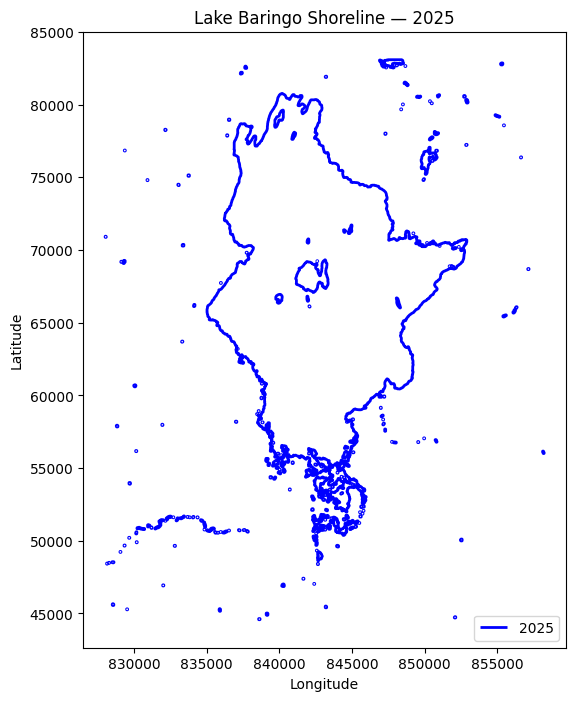

In [34]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

shorelines = [
    (2007, dissolved_2007),
    (2016, dissolved_2016),
    (2025, dissolved_2025)
]

fig, ax = plt.subplots(figsize=(8, 8))

# # Plot DEM or hillshade background once
# dem.plot(ax=ax, cmap='terrain', alpha=0.6)
# ax.set_title("Lake Baringo Shoreline — 2016")

# Store current shoreline plot handle
shore_plot = [None]

def plot_frame(year, gdf, color='blue'):
    # Remove previous shoreline if it exists
    if shore_plot[0] is not None:
        for c in shore_plot[0].collections:
            c.remove()
    
    # Plot new shoreline (outline only)
    shore_plot[0] = gdf.boundary.plot(ax=ax, color=color, linewidth=2, label=str(year))
    ax.legend([str(year)], loc='lower right')
    ax.set_title(f"Lake Baringo Shoreline — {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

def animate(i):
    year, gdf = shorelines[i]
    plot_frame(year, gdf)

ani = animation.FuncAnimation(fig, animate, frames=len(shorelines), interval=1800, repeat=True)

ani.save("lake_baringo_shoreline_growth.gif", writer="pillow", fps=1)
plt.show()